<a href="https://colab.research.google.com/github/ScoomenstheMumens/QiskitThesis-LGTQuantumSimulations/blob/main/manilaheis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!pip install retworkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime
!pip install mthree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
import numpy as np

from time import time
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler)
import random 
from qiskit import Aer

from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from qiskit.primitives import Estimator,Sampler,BackendSampler,BackendEstimator
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from qiskit.algorithms import NumPyEigensolver

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter,ParameterVector



from qiskit import IBMQ

from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector

from util import GEM_calibration_circuits,qiskit_calibration_circuits,occurrences_to_vector,bin_list,DecimalToBinary

from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.result import marginal_counts

from qiskit.opflow import X, Z, I,Y

from itselfmiti import bin_list


import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

import collections
import scipy.special as ss
import qiskit.result
from itselfmiti import bin_list
from qiskit import *
import mthree
from qiskit.result import marginal_counts

import itselfmiti
import util


In [119]:
edge_list=[(0,1),(2,3),(1,2),(3,4)]
measure_list=[[(0, 1),(2, 3)],
              [(1,2),(3,4)]]
def Hamiltonian_heisenberg(g):
  X1 = X^X^I^I^I
  Y1 = Y^Y^I^I^I
  Z1 = Z^Z^I^I^I
  X2 = I^X^X^I^I
  Y2 = I^Y^Y^I^I
  Z2 = I^Z^Z^I^I
  X3 = I^I^X^X^I
  Y3 = I^I^Y^Y^I
  Z3 = I^I^Z^Z^I
  X4 = I^I^I^X^X
  Y4 = I^I^I^Y^Y
  Z4 = I^I^I^Z^Z

  H=(g*X1) + \
    (g*X2) + \
    (g*X3) + \
    (g*X4) + \
    (g*Z1) + \
    (g*Z2) + \
    (g*Z3) + \
    (g*Z4) + \
    (g*Y1) + \
    (g*Y2) + \
    (g*Y3) + \
    (g*Y4)
  return H

In [120]:
ham=Hamiltonian_heisenberg(1)

In [121]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-7.71154501 -7.71154501 -4.82842712 -4.82842712 -3.23606798 -3.23606798
 -3.23606798 -3.23606798 -2.64327435 -2.64327435 -1.23606798 -1.23606798
 -1.23606798 -1.23606798  0.82842712  0.82842712  1.23606798  1.23606798
  1.23606798  1.23606798]


In [122]:
def symm_ans(depth,edges):
  qr_sym= QuantumRegister(5)
  qc_sym = QuantumCircuit(qr_sym)

  theta = ParameterVector("t",depth*len(edges))
  index=0
  for i in range (0,depth):
    for j,vert in enumerate(edges):
      qc_sym.h(qr_sym[vert[0]])
      qc_sym.cx(qr_sym[vert[0]],qr_sym[vert[1]])
      qc_sym.ry(theta[index],qr_sym[vert[0]])
      qc_sym.ry(theta[index],qr_sym[vert[1]])
      qc_sym.cx(qr_sym[vert[0]],qr_sym[vert[1]])
      qc_sym.h(qr_sym[vert[0]])
      index+=1
  return qc_sym

In [123]:
def symm_ans_terra(depth,edges,magn):
  qr_sym= QuantumRegister(5)
  qc_sym = QuantumCircuit(qr_sym)

  theta = ParameterVector("t",depth*len(edges))
  index=0
  qc_sym.x(qr_sym[i] for i in range (0,magn))
  for i in range (0,depth):
    for j,vert in enumerate(edges):
      qc_sym.h(qr_sym[vert[0]])
      qc_sym.cx(qr_sym[vert[0]],qr_sym[vert[1]])
      qc_sym.ry(theta[index],qr_sym[vert[0]])
      qc_sym.ry(theta[index],qr_sym[vert[1]])
      qc_sym.cx(qr_sym[vert[0]],qr_sym[vert[1]])
      qc_sym.h(qr_sym[vert[0]])
      index+=1
  return qc_sym

In [124]:
def circs_to_run(ansatz,measure_list):
  circs=[]
  for i,measure in enumerate(measure_list):
    qr=QuantumRegister(5)
    qc=QuantumCircuit(qr)

    qc.append(ansatz,qr)
    for j,vert in enumerate(measure):
      qc.h(qr[vert[0]])
      qc.cx(qr[vert[0]],qr[vert[1]])
      qc.ry(np.pi/4,qr[vert[0]])
      qc.ry(np.pi/4,qr[vert[1]])
      qc.cx(qr[vert[0]],qr[vert[1]])
      qc.h(qr[vert[0]])
    qc.measure_all()
    circs.append(qc)
  return circs

In [125]:
def GEM_calibration_circuits_symm(qc,state_labels):
    '''
    returns the calibration circuits for the mitigation tecnique GEM.
    '''

    
    calib_circuits = [[],[]]
    N_qubits = len(qc.qubits)
    
    qc_half_1, qc_half_2 = itselfmiti.GEM_half_circuits(qc)
    # first half
    qr_1 = QuantumRegister(N_qubits, name="q")
    qc_cal_1 = QuantumCircuit(qr_1, name="cal_1")
    qc_cal_1.append(qc_half_1, qr_1)
    qc_cal_1.append(qc_half_1.inverse(), qr_1)
    
    qr_2 = QuantumRegister(N_qubits, name="q")
    qc_cal_2 = QuantumCircuit(qr_2, name="cal_2")
    qc_cal_2.append(qc_half_2, qr_2)
    qc_cal_2.append(qc_half_2.inverse(), qr_2)
    
    half_circuits = [qc_cal_1, qc_cal_2]
    # prepare all the initial state.
    for i in range(2):
        for state in state_labels:
            qr_cal = QuantumRegister(N_qubits, name = "q_")
            qc_cal = QuantumCircuit(qr_cal, name=f"mcalcal_{state}")
            
            for qubit in range(N_qubits):
                if state[::-1][qubit] == "1":
                    qc_cal.x(qr_cal[qubit])
            # than we append the circuit
            qc_cal.append(half_circuits[i], qr_cal)
            qc_cal.measure_all()
            calib_circuits[i].append(qc_cal)
    return calib_circuits, state_labels

In [126]:

def circs_to_mitigate(ansatz,measure_list,magn,num_states):
  circs_miti=[]
  state_labels_miti=[]
  circs=circs_to_run(ansatz,measure_list)
  for circ in circs:
    qr=QuantumRegister(5)
    qc=QuantumCircuit(qr)

    bin_list_magn=itselfmiti.bin_list(num_qubits,magn)
    bin_list_magn=random.sample(bin_list_magn,num_states)

    circs_GEM,state_labels=GEM_calibration_circuits_symm(ansatz,bin_list_magn)
    circs_miti+=circs_GEM[0]
    circs_miti+=circs_GEM[1]
    state_labels_miti.append(state_labels)
  return circs_miti,state_labels_miti

In [127]:
def entangled_magn_state(num_qubits,magn):
  a=bin_list(num_qubits,magn)
  b=list(np.ones(len(a))/ss.binom(num_qubits,magn))
  new_dict=dict(zip(a,b))
  return new_dict


In [128]:
def sum_string(string):
  value = 0
  for char in string:
    value += int(char)
  return value

In [129]:

num_qubits=2
states=bin_list(num_qubits)
val=np.ones(len(states))
heis=dict(zip(states,val))
for i in range(2**(num_qubits-2),2**(num_qubits-2)+2**(num_qubits-2)):
  heis[states[i]]-=4

In [130]:
heis

{'00': 1.0, '01': -3.0, '10': 1.0, '11': 1.0}

In [131]:
spsa = SPSA(maxiter=100,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=10,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=100, disp=True, rhobeg=2.0, tol=1e-3, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)

In [132]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        '''
        x0=np.ones(self._circuit.num_parameters)
        x0 = x0*np.pi/2 #* np.random.rand(self._circuit.num_parameters)
        '''
        x0=np.ones(self._circuit.num_parameters)*np.pi/4
        #x0 =np.random.rand(self._circuit.num_parameters)*np.pi/2
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -7.62768030732287,
    'optimal_circuit': None,
    'optimal_parameters': array([1.26889743, 1.99241322, 1.63913313, 0.34140841, 0.55937072,
       1.55049281, 2.99250372, 2.09073825]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 1.26


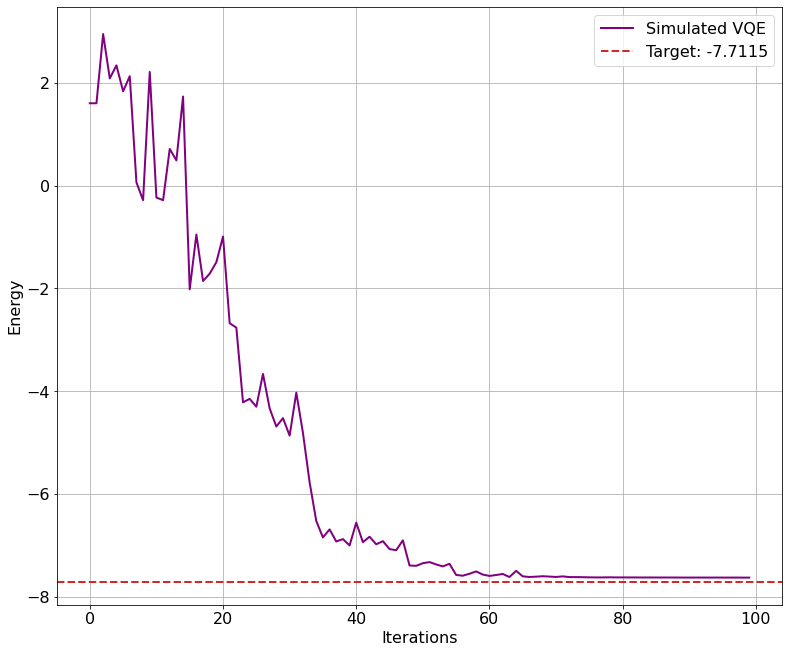

In [133]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([symm_ans_terra(2,edge_list,3)], [ham])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, symm_ans_terra(2,edge_list,3), cobyla, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
plt.figure(figsize=(13,11))
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [134]:
x0=result.optimal_parameters

In [135]:
print(x0)

[1.26889743 1.99241322 1.63913313 0.34140841 0.55937072 1.55049281
 2.99250372 2.09073825]


In [136]:

shots=20000
magn=3
num_qubits=5
depth=2

#BACKEND=backend_sim_ideal
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class DEPCustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,time_start,num_qubits=5,magn=3,depth=2,p=np.zeros(2),callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._p=np.zeros(2)
        self._time_start=time_start
        self._depth=2
        self._num_qubits=5
        self._magn=3
        
    def compute_minimum_eigenvalue(self):
                
        # Define objective function to classically minimize over
        def objective(x):
            num_qubits=self._num_qubits
            depth=self._depth
            magn=self._magn
            
            energy_noisy=0
            qc_aux=self._circuit
            qr=QuantumRegister(num_qubits)
            qc=QuantumCircuit(qr)
            for i in range (0,magn):
              qc.x(qr[i])
            qc.append(self._circuit,qr)
            qc_cal_bound=qc.assign_parameters(x)
            if (self._p[0]==0 or (time()-self._time_start)>1500):
              print('calibration')
              
              circs_run=circs_to_run(qc_cal_bound,measure_list)
              circs_miti,s_labels=circs_to_mitigate(qc_aux.assign_parameters(x),measure_list,magn,4)
              circs=[]
              circs+=circs_run
              circs+=circs_miti
              #circs=transpile(circs,BACKEND,optimization_level=0)
              print(len(circs))
              job = self._sampler.run(circuits=circs,parameter_values=None, parameters=None,shots=shots)
              job_result=job.result().quasi_dists
              #qc_cal_bound.measure_all()

              
              new_dict=[]
              for i in range (0,len(job_result)):
                b=list(job_result[i].keys())
                for j in range (0,len(b)):
                  b[j]=util.DecimalToBinary(b[j],self._num_qubits)
                a=list(job_result[i].values())
                new_dict.append(dict(zip(b,a)))
              noisy_exp_counts=[]
              print(new_dict)
              for i,noisy in enumerate(new_dict):
                for key in noisy.keys():
                  if sum_string(key) != magn:
                      noisy[key] = 0
                norm = np.sum(occurrences_to_vector(noisy))
                for key in noisy.keys():
                  noisy[key] = noisy[key]/norm*shots
                noisy_exp_counts.append(noisy)
              
              for j in range (0,len(measure_list)):
                p_t=0
                for i,output in enumerate(s_labels[j]):
                        if output in noisy_exp_counts[2+i+2*j*len(s_labels[j])]:
                            p_t += (noisy_exp_counts[2+i+2*j*len(s_labels[j])][output]/shots-1)/(1/ss.binom(num_qubits,magn)-1)
                            #print(p_t)
                        else:
                            p_t += 0
                        if output in noisy_exp_counts[2+len(s_labels[j])+i+2*j*len(s_labels[j])]:
                            p_t += (noisy_exp_counts[2+len(s_labels[j])+i+2*j*len(s_labels[j])][output]/shots-1)/(1/ss.binom(num_qubits,magn)-1)
                            #print(p_t)
                        else:
                            p_t += 0
                self._p[j]=p_t/(2*len(s_labels[j]))
                print('p')
                print(p_t)
            else:
              circs,num_qubits=circs_to_run(qc_cal_bound,measure_list)
              job = self._sampler.run(circuits=circs,parameter_values=None, parameters=None,shots=shots)
              job_result=job.result().quasi_dists
              #qc_cal_bound.measure_all()
              new_dict=[]
              for i in range (0,len(job_result)):
                b=list(job_result[i].keys())
                for j in range (0,len(b)):
                  b[j]=DecimalToBinary(b[j],self._num_qubits)
                a=list(job_result[i].values())
                new_dict.append(dict(zip(b,a)))
              noisy_exp_counts=[]
              for i,noisy in enumerate(new_dict):
                for key in noisy.keys():
                  if sum_string(key) != magn:
                      noisy[key] = 0
                norm = np.sum(occurrences_to_vector(noisy))
                for key in noisy.keys():
                  noisy[key] = noisy[key]/norm*shots
                noisy_exp_counts.append(noisy)
            for i,meas in enumerate(measure_list):
              ent_symm=entangled_magn_state(num_qubits,magn)
              for vert in meas:
                ent_symm_vert=marginal_counts(ent_symm,[vert[0],vert[1]])
                noisy_counts_vert=marginal_counts(noisy_exp_counts[i],[vert[0],vert[1]])
                energy_dep_string=mthree.utils.expval(ent_symm_vert,heis)
                #print(energy_dep_string)
                energy_noisy_string=mthree.utils.expval(noisy_counts_vert,heis)
                #print(energy_noisy_string)
                energy_mitigated=(energy_noisy_string-self._p[i]*energy_dep_string)/(1-self._p[i])
                energy_noisy+=energy_mitigated
            # Save result information using callback function

            estimator=Estimator([qc_cal_bound],[ham])
            job=estimator.run([qc_cal_bound], [ham], parameters=None)
            
            print(job.result().values[0])
            if self._callback is not None:
                self._callback(energy_noisy)   
                print('iterations energy')
                print('energy_noisy')
                print(energy_noisy)
            return energy_noisy
            
        # Select an initial point for the ansatzs' parameters

        x0=np.ones(self._circuit.num_parameters)*np.pi/4
        #x0=np.random.rand(self._circuit.num_parameters)

        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

calibration
18
[{'00000': 0.0, '00001': 0.0, '00010': 0.0, '00011': 0.0, '00100': 0.0, '00101': 0.0, '00110': 0.0, '00111': 0.0044, '01000': 0.0, '01001': 0.0, '01010': 0.0, '01011': 0.08445, '01100': 0.0, '01101': 0.01785, '01110': 0.04215, '01111': 0.0, '10000': 0.0, '10001': 0.0, '10010': 0.0, '10011': 0.11345, '10100': 0.0, '10101': 0.04425, '10110': 0.14645, '10111': 0.0, '11000': 0.0, '11001': 0.06545, '11010': 0.4655, '11011': 0.0, '11100': 0.01605, '11101': 0.0, '11110': 0.0, '11111': 0.0}, {'00000': 0.0, '00001': 0.0, '00010': 0.0, '00011': 0.0, '00100': 0.0, '00101': 0.0, '00110': 0.0, '00111': 0.0614, '01000': 0.0, '01001': 0.0, '01010': 0.0, '01011': 0.0304, '01100': 0.0, '01101': 0.1217, '01110': 0.0326, '01111': 0.0, '10000': 0.0, '10001': 0.0, '10010': 0.0, '10011': 0.06365, '10100': 0.0, '10101': 0.56795, '10110': 0.0617, '10111': 0.0, '11000': 0.0, '11001': 0.03085, '11010': 0.0, '11011': 0.0, '11100': 0.02975, '11101': 0.0, '11110': 0.0, '11111': 0.0}, {'00000': 0.0, 

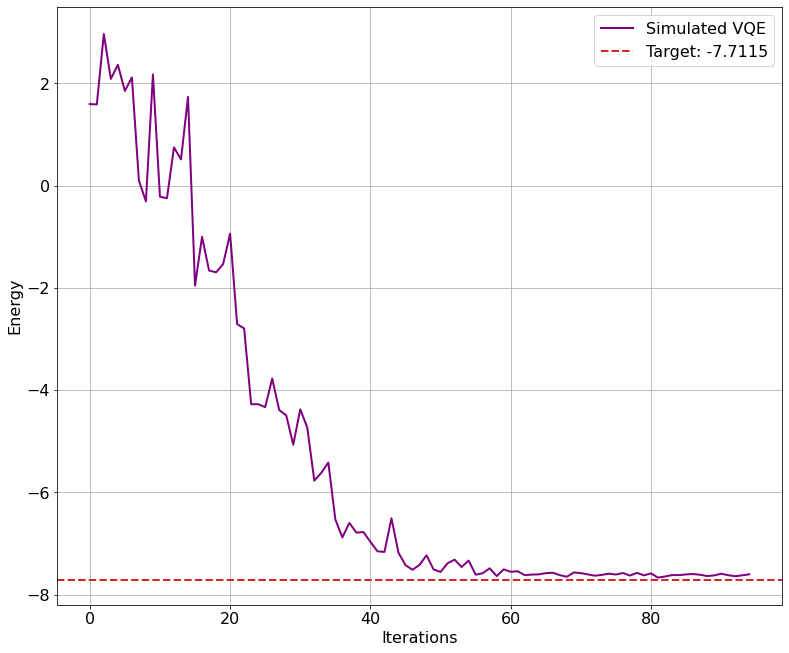

In [137]:

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()

# Setup VQE algorithm
custom_vqe = DEPCustomVQE(estimator, symm_ans(2,edge_list),cobyla, time(),p=[0,0],callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue()
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
plt.figure(figsize=(13,11))
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [142]:

from qiskit_aer.noise import NoiseModel
from qiskit.utils import QuantumInstance, algorithm_globals
# Get fake backend if you like
from qiskit.providers.fake_provider import FakeManila

# Noisy simulator backend
device_backend = FakeManila()
#noise_model = NoiseModel.from_backend(device_backend)
#IBMQ.disable_account()
#provider = IBMQ.enable_account('c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
IBMQ.update_account()
print(IBMQ.providers())


provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta


backend=backend_real_jakarta

QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True, token='c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
service = QiskitRuntimeService(channel='ibm_quantum',instance='ibm-q/open/main')

Found 0 credentials.
No credentials available for updating could be found. No action will be performed.
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='qc-fall-22-8', group='group-2', project='recrQvTQ0hTCoLumW')>]


In [143]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)
        #print(value)

In [144]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options


# Setup Estimator
start = time()
options = Options()
options.optimization_level = 1
options.resilience_level = 0
with Session(service=service, backend=backend_real_jakarta) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    # Set up algorithm
    custom_vqe = DEPCustomVQE(rt_estimator, symm_ans(2,edge_list), cobyla, time(),p=[0,0], callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue()
end = time()
print(f'execution time (s): {end - start:.2f}')

calibration
18


QiskitBackendNotFoundError: ignored